In [1]:
#import modules
import numpy as np
import pandas as pd
import time
from keras import backend as K 
from keras.engine.training import Model
from keras.utils import to_categorical, plot_model
from keras.models import Sequential, load_model
from sklearn.preprocessing import MinMaxScaler
from keras.layers.convolutional import Conv1D, Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import Dropout, Activation, Flatten
from keras.layers import LSTM, Dense, Input
from keras.optimizers import SGD
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from tqdm import tqdm_notebook
from sklearn.metrics import mean_squared_error

In [2]:
#import data
df = pd.read_csv('../Sub0-RAW.csv')
df.head()

,Dates,Year,Month,Day,Hours,Precipitation,Temperature,Outflow
0,10/1/1980,1980,10,1,0:00:00,0.0,102.992,5.0
1,10/1/1980,1980,10,1,1:00:00,0.0,97.790,5.0
2,10/1/1980,1980,10,1,2:00:00,0.0,92.588,5.0
3,10/1/1980,1980,10,1,3:00:00,0.0,87.404,5.0
4,10/1/1980,1980,10,1,4:00:00,0.0,85.172,5.0


In [3]:
#define train and label column
train_cols = ["Precipitation","Temperature","Outflow"]

In [4]:
#filter the columns
new_df = df.filter(train_cols, axis=1)

In [5]:
new_df['ExtremeOrNot'] = np.where(new_df['Outflow'] > 250, 1, 0)

In [6]:
#label of network for discriminator network
labels_discriminator = ["ExtremeOrNot"]

In [7]:
#Min Max scalr normalizing
xtrain_min_max_scaler = MinMaxScaler(feature_range = (0, 1))
ytrain_min_max_scaler = MinMaxScaler(feature_range = (0, 1))
xtest_min_max_scaler = MinMaxScaler(feature_range = (0, 1))
ytest_min_max_scaler = MinMaxScaler(feature_range = (0, 1))

In [9]:
#function to shift the time_series data for getting labels
def lag_seq(df, n_seq):
    for i in range(n_seq):
        df['Outflow(t+%d)' %(i+1)] = new_df['Outflow'].shift(-(i+1))
    return df

#calling function to create lag dataframe
lag_df = lag_seq(new_df, 1)
lag_df.dropna(inplace=True)

#Splitting training and test data
df_train, df_test = train_test_split(lag_df, train_size=0.8, test_size=0.2, shuffle=False)
x_train = df_train.loc[:,train_cols].values
y_train_dis = df_train.loc[:,labels_discriminator].values  #for discriminator
x_test = df_test.loc[:,train_cols].values
y_test_dis = df_test.loc[:,labels_discriminator].values    #for discriminator

In [10]:
# building timeseries data with given timesteps
def timeseries(X, Y, Y_actual, time_steps, out_steps):
    input_size_0 = X.shape[0] - time_steps
    input_size_1 = X.shape[1]
    X_values = np.zeros((input_size_0, time_steps, input_size_1))
    Y_values = np.zeros((input_size_0,))
    Y_values_actual = np.zeros((input_size_0,))
    
    for i in tqdm_notebook(range(input_size_0)):
        X_values[i] = X[i:time_steps+i]
        Y_values[i] = Y[time_steps+i-1, 0]
        Y_values_actual[i] = Y_actual[time_steps+i-1, 0]
        
    print("length of time-series i/o",X_values.shape,Y_values.shape)
    return X_values, Y_values, Y_values_actual

In [11]:
# data for Network3
def data_processing1(x_train, y_train, x_test, y_test): 
   
    #Normalizing training data
    x_train_nor = xtrain_min_max_scaler.fit_transform(x_train)

    # Normalizing test data
    x_test_nor = xtest_min_max_scaler.fit_transform(x_test)
    
    # Saving actual train and test y_label
    y_train_actual = y_train
    y_test_actual = y_test
    
    #Building timeseries
    X_Train, Y_Train, Y_train_actual = timeseries(x_train_nor, y_train, y_train_actual, time_steps=18, out_steps=1)
    X_Test, Y_Test, Y_test_actual = timeseries(x_test_nor, y_test, y_test_actual, time_steps=18, out_steps=1)
    
    return X_Train, Y_Train, Y_train_actual, X_Test, Y_Test, Y_test_actual

In [12]:
#calling function to create lag dataframe for distinguisher network
X_Train_dis, Y_Train_dis, Y_train_actual_dis, X_Test_dis, Y_Test_dis, Y_test_actual_dis = data_processing1(x_train, 
                                                                                                          y_train_dis, 
                                                                                                          x_test, 
                                                                                                          y_test_dis)

/home/bidur/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':



length of time-series i/o (148415, 18, 3) (148415,)



length of time-series i/o (37091, 18, 3) (37091,)


In [20]:
Y_Train_dis = to_categorical(Y_Train_dis)

In [22]:
Y_Test_dis = to_categorical(Y_Test_dis)

In [15]:
def make_model2(X_Train):
    inp = Input(shape=(X_Train.shape[1], X_Train.shape[2]))
    #build modelA
    lstm1 = LSTM(units=16, return_sequences=True, 
                   name = 'lstm1A')(inp)
#     do1A = Dropout(0.2, name = 'do1A')(lstm1A)
    lstm2 = LSTM(units=32, return_sequences=True,
                  name = 'lstm2A')(lstm1)
#     do2A = Dropout(0.2, name = 'do2A')(lstm2A)
    lstm3 = LSTM(units=64, name = 'lstm3A')(lstm2)
#     do3A = Dropout(0.2, name = 'do3A')(lstm3A)
    
    dense1 = Dense(128, activation='relu')(lstm3)
    dense2 = Dense(64, activation='relu')(dense1)
    output_layer = Dense(2, activation='softmax')(dense2)
    
    return Model(inputs=inp, outputs=output_layer)

In [ ]:
# Network3 Training
# mse_for_iter2 = []
train_loss_over_epoch2 = []
val_loss_over_epoch2 = []
all_actual_values = []
models2 = []
def run_iteration2(no_iter=20, epochs = 10):
    start_time = time.time()
    for iteration in range(no_iter):
        print(f'Iteration: {iteration + 1}')
        K.clear_session()
        model2 = make_model2(X_Train)
        #plot_model(model, show_shapes=True)
        model2.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics= ['accuracy'])
        history = model2.fit(X_Train, Y_Train_dis, epochs=epochs,
                       validation_data=(X_Test, Y_Test_dis))
        train_loss_over_epoch2.append(history.history['loss'])
        val_loss_over_epoch2.append(history.history['val_loss'])
        predicted_y_values2 = model2.predict(X_Test)
#         predicted_y_values_unnor2 = ytrain_min_max_scaler.inverse_transform(predicted_y_values2)
#         mse_for_iter2.append(mean_squared_error(predicted_y_values_unnor, Y_test_actual))
        actual_values = np.argmax(predicted_y_values2, axis = 1)
#         predicted_y_values_unnors.append(actual_values)
        models2.append(model2)
        
    end_time = time.time()
    print('--------------------------\n')
    print(f'Starting time: {start_time}')
    print(f'Completing time: {end_time}')
    print(f'It took {(start_time - end_time)/60} minutes to train the model for {no_iter} iterations')
    #return predicted unnormalized values for test set from last iteration 
    return actual_values, model2

actual_values, model2 = run_iteration(1,10)

In [23]:
model2 = make_model2(X_Train_dis)
model2.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics= ['accuracy'])
history = model2.fit(X_Train_dis, Y_Train_dis, epochs=10,
                       validation_data=(X_Test_dis, Y_Test_dis))

Epoch 1/10
4638/4638 [==============================] - 87s 18ms/step - loss: 0.0344 - accuracy: 0.9938 - val_loss: 0.0038 - val_accuracy: 0.9982
Epoch 2/10
4638/4638 [==============================] - 73s 16ms/step - loss: 0.0037 - accuracy: 0.9985 - val_loss: 0.0072 - val_accuracy: 0.9977
Epoch 3/10
4638/4638 [==============================] - 124s 27ms/step - loss: 0.0024 - accuracy: 0.9991 - val_loss: 0.0029 - val_accuracy: 0.9987
Epoch 4/10
4638/4638 [==============================] - 129s 28ms/step - loss: 0.0026 - accuracy: 0.9990 - val_loss: 0.0023 - val_accuracy: 0.9990
Epoch 5/10
4638/4638 [==============================] - 127s 27ms/step - loss: 0.0022 - accuracy: 0.9992 - val_loss: 0.0022 - val_accuracy: 0.9989
Epoch 6/10
4638/4638 [==============================] - 128s 28ms/step - loss: 0.0020 - accuracy: 0.9992 - val_loss: 0.0014 - val_accuracy: 0.9997
Epoch 7/10
4638/4638 [==============================] - 128s 28ms/step - loss: 0.0021 - accuracy: 0.9991 - val_loss: 0.0

In [25]:
predicted_y_values2 = model2.predict(X_Test_dis)

In [26]:
predicted_y_values2

array([[1.0000000e+00, 4.9272838e-37],
       [1.0000000e+00, 9.4550042e-37],
       [1.0000000e+00, 1.5347571e-36],
       ...,
       [1.0000000e+00, 1.8985190e-32],
       [1.0000000e+00, 2.5985934e-32],
       [1.0000000e+00, 1.1273526e-32]], dtype=float32)

In [27]:
actual_values = np.argmax(predicted_y_values2, axis = 1)

In [28]:
actual_values

array([0, 0, 0, ..., 0, 0, 0])

In [29]:
np.unique(actual_values)

array([0, 1])

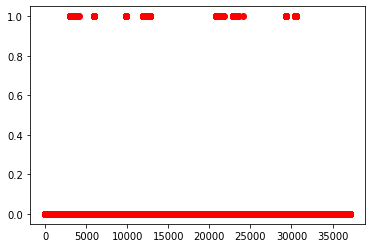

In [32]:
plt.plot(actual_values, 'ro')
plt.show()

In [ ]:
Y